In [50]:
!pip install bresenham
from bresenham import bresenham
import numpy as np 
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.figsize"] = [12, 12]

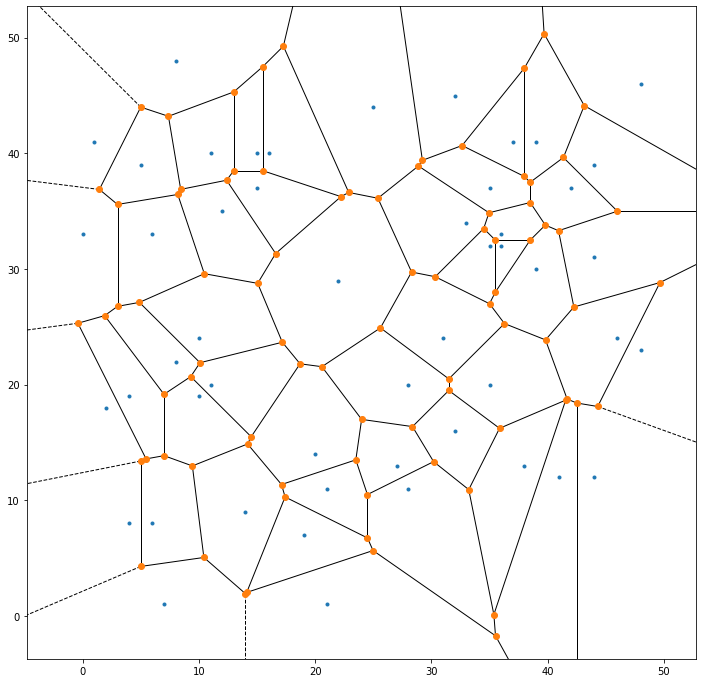

In [51]:
# Recreate the figure above for a new set of random points
points = np.random.randint(50, size=(50, 2))
graph = Voronoi(points)
voronoi_plot_2d(graph)
plt.show()

In [47]:
# Read in the obstacle data
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)

In [54]:
# Here you'll modify the `create_grid()` method from a previous exercise
# In this new function you'll record obstacle centres and
# create a Voronoi graph around those points
def create_grid_and_edges(data, drone_altitude, safety_distance):
    """
    Returns a grid representation of a 2D configuration space
    along with Voronoi graph edges given obstacle data and the
    drone's altitude.
    """

    # minimum and maximum north coordinates
    north_min = np.floor(np.min(data[:, 0] - data[:, 3]))
    north_max = np.ceil(np.max(data[:, 0] + data[:, 3]))

    # minimum and maximum east coordinates
    east_min = np.floor(np.min(data[:, 1] - data[:, 4]))
    east_max = np.ceil(np.max(data[:, 1] + data[:, 4]))

    # given the minimum and maximum coordinates we can
    # calculate the size of the grid.
    north_size = int(np.ceil((north_max - north_min)))
    east_size = int(np.ceil((east_max - east_min)))

    # Initialize an empty grid
    grid = np.zeros((north_size, east_size))
    # Center offset for grid
    north_min_center = np.min(data[:, 0])
    east_min_center = np.min(data[:, 1])
    
    # Define a list to hold Voronoi points
    points = []
    # Populate the grid with obstacles
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i, :]

        if alt + d_alt + safety_distance > drone_altitude:
            obstacle = [
                int(north - d_north - safety_distance - north_min_center),
                int(north + d_north + safety_distance - north_min_center),
                int(east - d_east - safety_distance - east_min_center),
                int(east + d_east + safety_distance - east_min_center),
            ]
            grid[obstacle[0]:obstacle[1], obstacle[2]:obstacle[3]] = 1
            
            # add center of obstacles to points list
            points.append([north - north_min, east - east_min])

    # TODO: create a voronoi graph based on
    # location of obstacle centres
    graph = Voronoi(points)
    # TODO: check each edge from graph.ridge_vertices for collision
    edges = []
    for edge in graph.ridge_vertices:
        point1 = graph.vertices[edge[0]]
        point2 = graph.vertices[edge[1]]
        
        cells = list(bresenham(int(point1[0]), int(point1[1]), int(point2[0]), int(point2[1])))
        infeasible = False
        
        for cell in cells:
            if np.amin(cell) < 0 or cell[0] >= grid.shape[0] or cell[1] >= grid.shape[1]:
                infeasible = True
                break
            if grid[cell[0], cell[1]] == 1:
                infeasible = True
                break
        if infeasible == False:
            point1 = (point1[0], point1[1])
            point2 = (point2[0], point2[1])
            edges.append((point1,point2))

    return grid, edges


In [55]:
# Define a flying altitude (feel free to change this)
drone_altitude = 5
safety_distance = 3
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print('Found %5d edges' % len(edges))


Found  1495 edges


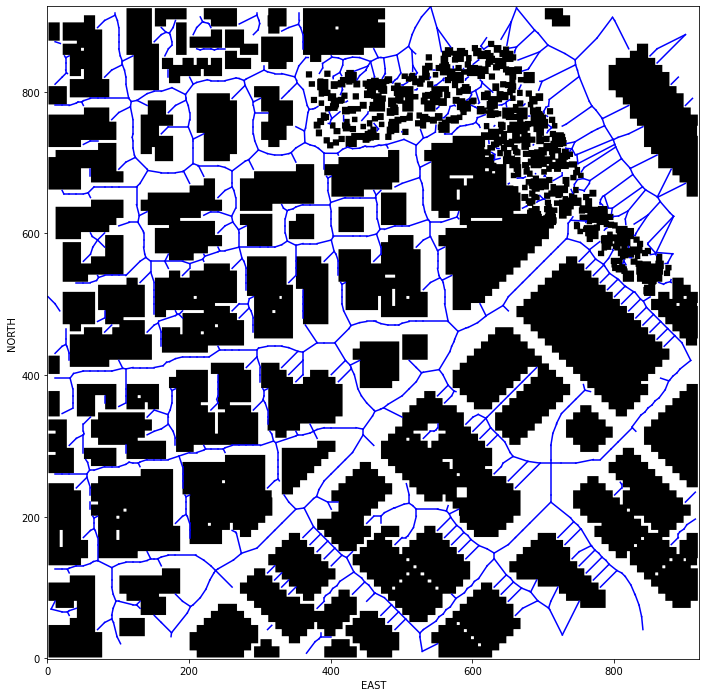

In [56]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
# Plot it up!
plt.imshow(grid, origin='lower', cmap='Greys') 

# Stepping through each edge
for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()
